# Import Libraries

In [1]:
import os
import random
import sys
from datetime import datetime
from itertools import cycle
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchinfo import summary
from tqdm import tqdm
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Datasets

In [3]:
BATCH_SIZE = 128

## Data Augmentations

In [4]:
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]

# train_transforms = T.Compose([
#     T.Resize((48, 48)),
#     T.ToTensor(),
#     T.RandomHorizontalFlip(p=0.5),
#     T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     T.Normalize(mean, std),
#     T.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2))
# ])

mean = [0.485]  # Single channel
std = [0.229]

train_transforms = T.Compose([
    T.Grayscale(num_output_channels=3),  # Keep 3 channels but use grayscale
    T.RandomApply([T.RandomRotation(15)], p=0.5),
    T.RandomPerspective(distortion_scale=0.3, p=0.3),
    T.RandomResizedCrop(48, scale=(0.8, 1.2)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
    T.RandomErasing(p=0.2)  # Helps with occlusion
])

val_transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

## DataSet and DataLoader

In [5]:
fer_2013_dir = Path(os.getcwd(), 'datasets', 'fer2013')

In [6]:
training_set = ImageFolder(root=fer_2013_dir / 'train', transform=train_transforms)
training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = ImageFolder(root=fer_2013_dir / 'test', transform=val_transforms)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Print shape of training and testing images
print(f"Training set: {len(training_set)} images")
print(f"Testing set: {len(test_set)} images")

for images, labels in training_loader:
  break

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

Training set: 28709 images
Testing set: 7178 images
One image batch shape : torch.Size([128, 3, 48, 48])
One label batch shape : torch.Size([128])


In [8]:
print(training_set.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [9]:
label_map = {
    0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 
    4: 'neutral', 5: 'sad', 6: 'surprise'
}

#### Show sample images

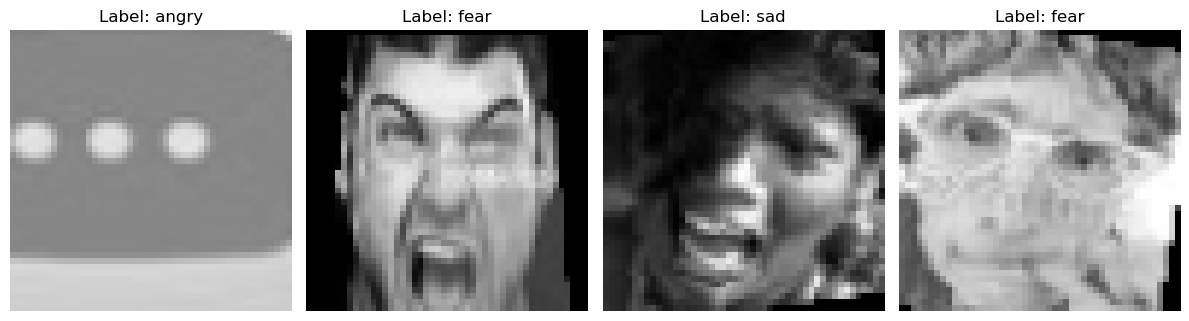

In [10]:
# Get a batch
images, labels = next(iter(training_loader))

# Unnormalize a few images from the batch
def unnormalize(img):
    # Use values matching your actual normalization
    mean = torch.tensor([0.485, 0.485, 0.485]).to(img.device)
    std = torch.tensor([0.229, 0.229, 0.229]).to(img.device)
    return img * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)

# Display with proper channel handling
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    img = unnormalize(images[i].unsqueeze(0)).squeeze(0)
    img = img.permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img, cmap='gray')  # Force grayscale display
    axes[i].set_title(f"Label: {label_map[int(labels[i])]}")
    axes[i].axis("off")
    
plt.tight_layout()
plt.show()

# Base Model

### Define Class

In [11]:
class BaseFERModel(nn.Module):
    def __init__(self, params):
        super(BaseFERModel, self).__init__()
        num_classes = params['num_classes']

        # First convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 32x24x24
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 48, 48)
            out = self.layer1(dummy_input)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = self.layer6(out)
            flattened_size = out.view(1, -1).size(1)


        # Fully connected (dense) layers
        #self.fc1 = nn.Linear(in_features=1024*1*1, out_features=1024)
        self.fc1 = nn.Linear(in_features=flattened_size, out_features=1024)
        self.dropout = nn.Dropout(params['dropout_rate'])
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
       
        #self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, return_embeddings=False):
        output = self.layer1(x)  #  first layer
        output = self.layer2(output)  # second layer
        output = self.layer3(output)  # third layer
        output = self.layer4(output)  # fourth layer
        output = self.layer5(output)  # fifth layer
        output = self.layer6(output)  # sixth layer        
        output = output.view(output.size(0), -1)  # Flatten for the fully connected layers
        
        # Embedding extraction (no dropout)
        embeddings = F.relu(self.fc1(output))
        embeddings = self.fc2(embeddings)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Classification head (with dropout)
        #logits = self.dropout(F.relu(embeddings))  # Reintroduce dropout here
        logits = self.dropout(embeddings)
        logits = self.fc3(logits)
        
        return (logits, embeddings) if return_embeddings else logits

In [5]:
class BaseFERModel_V2(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.features = nn.Sequential(
            # Stem
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            
            # FER-Specialized Blocks
            DepthwiseSeparableConv(64, 128),
            DepthwiseSeparableConv(128, 256),
            DepthwiseSeparableConv(256, 512),
            
            nn.AdaptiveAvgPool2d((1,1))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(256, params['num_classes'])
        )
        
    def forward(self, x, return_embeddings=False):
        # Feature extraction
        x = self.features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        if return_embeddings:
            # Return embeddings before final classifier
            embeddings = self.classifier[:-1](x)
            logits = self.classifier[-1:](embeddings)
            return logits, embeddings
        
        # Full classification
        return self.classifier(x) # logits

def DepthwiseSeparableConv(in_c, out_c):
    return nn.Sequential(
        # Depthwise
        nn.Conv2d(in_c, in_c, 3, padding=1, groups=in_c, bias=False),
        nn.BatchNorm2d(in_c),
        nn.LeakyReLU(0.1),
        # Pointwise
        nn.Conv2d(in_c, out_c, 1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(2)
    )

### Compile Model

In [6]:
params={
        "initial_filters": 8,    
        "dropout_rate": 0.2,
        "num_classes": 7}

#base_fer_model = BaseFERModel(params).to(device)
base_fer_model = BaseFERModel_V2(params).to(device)
print(summary(base_fer_model, input_size=(BATCH_SIZE, 3, 48, 48), device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
BaseFERModel_V2                          [128, 7]                  --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 48, 48]         1,728
│    └─BatchNorm2d: 2-2                  [128, 64, 48, 48]         128
│    └─LeakyReLU: 2-3                    [128, 64, 48, 48]         --
│    └─MaxPool2d: 2-4                    [128, 64, 24, 24]         --
│    └─Sequential: 2-5                   [128, 128, 12, 12]        --
│    │    └─Conv2d: 3-1                  [128, 64, 24, 24]         576
│    │    └─BatchNorm2d: 3-2             [128, 64, 24, 24]         128
│    │    └─LeakyReLU: 3-3               [128, 64, 24, 24]         --
│    │    └─Conv2d: 3-4                  [128, 128, 24, 24]        8,192
│    │    └─BatchNorm2d: 3-5             [128, 128, 24, 24]        256
│    │    └─LeakyReLU: 3-6               [128, 128, 24, 24]        --
│    

In [8]:
import onnx
base_fer_model = BaseFERModel_V2(params).to('cpu')
base_fer_model.eval()

input = torch.rand(1,3,48,48)
torch.onnx.export(base_fer_model, input, "ourbasemodel.onnx", verbose=False, 
                 input_names=["input_names"], output_names=["output_names"],
                 export_params=True,)

C:\Users\oreda\AppData\Local\Temp\ipykernel_47144\970727120.py:34: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_embeddings:


# Create Train and Test functions

### Define functions

In [13]:
def calculate_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1, dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.cuda.FloatTensor))

In [14]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, current_epoch, epochs):
    """
    Train one epoch of the model.

    Args:
        model (nn.Module): The  model.
        dataloader (DataLoader): DataLoader for training data.
        device (torch.device): Device to train the model on (CPU/GPU).

    Returns:
        training_loss (float): Returns epoch_loss / len(dataloader)
    """
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    tk = tqdm(dataloader, desc="EPOCH" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(epochs))

    for t, data in enumerate(tk):
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Compute log probabilities from model
        logits = model(images)
        loss = criterion(logits, labels)

        # Backpropagation
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss for logging; Total loss
        epoch_loss += loss.item()
        
        epoch_accuracy += calculate_accuracy(logits, labels)

        # Print/log training loss and accuracy for this epoch
        tk.set_postfix({
            'loss': '%6f' % float(epoch_loss / (t + 1)), 
            'acc': '%6f' % float(epoch_accuracy / (t + 1))
        })

    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [15]:
def test_one_epoch(model, dataloader, criterion, device, current_epoch, epochs):
    """
    Test one epoch of the model

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): DataLoader for training data.
        learning_rate (float): Learning rate for optimizer.
        device (torch.device): Device to train the model on (CPU/GPU).

    Returns:
        training_loss (float): Returns epoch_loss / len(dataloader)
        
        running_acc (float): Returns epoch accuracy
    """
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    tk = tqdm(dataloader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(epochs))

    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for testing
        for t, data in enumerate(tk):          
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            # Compute log probabilities from model
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)            

            # Compute loss
            loss = criterion(logits, labels)

            # Accumulate loss for logging; Total loss
            epoch_loss += loss.item()
            
            epoch_accuracy += calculate_accuracy(logits, labels)
            

            tk.set_postfix({
                'loss': '%6f' % float(epoch_loss / (t + 1)), 
                'acc': '%6f' % float(epoch_accuracy / (t + 1))
            })

    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [16]:
def train_and_validate_model(model, training_dataloader, testing_dataloader, epochs, learning_rate, device):
    """
    Train and Test the speech recognition model using CTC loss.

    Args:
        model (nn.Module): The model.
        training_dataloader (DataLoader): DataLoader for training data.
        testing_dataloader (DataLoader): DataLoader for testing data.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for optimizer.
        device (torch.device): Device to train the model on (CPU/GPU).
    """
    # Define Loss function
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
    
    optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    # Move model to device
    model.to(device)

    best_valid_loss = np.inf
    patience_counter = 0   # Tracks the number of epochs without improvement
    early_stop = False # Flag to indicate whether to stop training
    save_weights_patience = 5

    # Dictionary to store loss and accuracy values over epochs
    history_metrics = {
        'training_loss': [],
        'training_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': []
    }

    for epoch in range(epochs):
        if early_stop:
            print("Early stopping triggered. Stopping training.")
            break

        print(f"Epoch {epoch + 1}, LR: {scheduler.optimizer.param_groups[0]['lr']}")

        # Training step
        train_loss, train_accuracy = train_one_epoch(model, training_dataloader, criterion, optimizer, device, epoch, epochs)
        
        # Testing step
        valid_loss, valid_accuracy = test_one_epoch(model, testing_dataloader, criterion, device, epoch, epochs) 

        history_metrics['training_loss'].append(train_loss)
        history_metrics['validation_loss'].append(valid_loss)
        history_metrics['training_accuracy'].append(train_accuracy)
        history_metrics['validation_accuracy'].append(valid_accuracy)

        # Update the learning rate based on validation loss and print
        #scheduler.step(valid_loss)

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), 'weights/base_model_with_fer2013_weights.pt')
            print("SAVED-BEST-WEIGHTS!")
            best_valid_loss = valid_loss
            patience_counter = 0 # Reset early stopping
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= save_weights_patience:
            print("Patience exceeded. Early stopping at epoch " +str(epoch + 1))
            early_stop = True
            
        
    print("")
    return history_metrics

### Run train functions

In [20]:
time1 = datetime.now()

In [21]:
# Train the model:
base_model_losses = train_and_validate_model(base_fer_model, training_loader, test_loader, epochs=50, learning_rate=0.001, device=device)

Epoch 1, LR: 0.002


EPOCH[VALID]1/50: 100%|██████████| 57/57 [00:20<00:00,  2.84it/s, loss=1.531349, acc=0.407237]


SAVED-BEST-WEIGHTS!
Epoch 2, LR: 0.002


EPOCH[VALID]2/50: 100%|██████████| 57/57 [00:03<00:00, 16.56it/s, loss=1.385648, acc=0.476261]


SAVED-BEST-WEIGHTS!
Epoch 3, LR: 0.002


EPOCH[VALID]3/50: 100%|██████████| 57/57 [00:03<00:00, 16.37it/s, loss=1.378405, acc=0.476206]


SAVED-BEST-WEIGHTS!
Epoch 4, LR: 0.002


EPOCH[VALID]4/50: 100%|██████████| 57/57 [00:03<00:00, 16.53it/s, loss=1.331536, acc=0.478262]


SAVED-BEST-WEIGHTS!
Epoch 5, LR: 0.002


EPOCH[VALID]5/50: 100%|██████████| 57/57 [00:03<00:00, 16.46it/s, loss=1.326619, acc=0.483553]


SAVED-BEST-WEIGHTS!
Epoch 6, LR: 0.002


EPOCH[VALID]6/50: 100%|██████████| 57/57 [00:03<00:00, 15.75it/s, loss=1.311136, acc=0.509814]


SAVED-BEST-WEIGHTS!
Epoch 7, LR: 0.002


EPOCH[VALID]7/50: 100%|██████████| 57/57 [00:04<00:00, 13.20it/s, loss=1.276729, acc=0.534814]


SAVED-BEST-WEIGHTS!
Epoch 8, LR: 0.002


EPOCH[VALID]8/50: 100%|██████████| 57/57 [00:13<00:00,  4.08it/s, loss=1.191492, acc=0.538569]


SAVED-BEST-WEIGHTS!
Epoch 9, LR: 0.002


EPOCH[VALID]9/50: 100%|██████████| 57/57 [00:04<00:00, 13.79it/s, loss=1.186137, acc=0.539693]


SAVED-BEST-WEIGHTS!
Epoch 10, LR: 0.002


EPOCH[VALID]10/50: 100%|██████████| 57/57 [00:03<00:00, 16.67it/s, loss=1.184348, acc=0.554879]


SAVED-BEST-WEIGHTS!
Epoch 11, LR: 0.002


EPOCH[VALID]11/50: 100%|██████████| 57/57 [00:03<00:00, 16.74it/s, loss=1.163231, acc=0.564501]


SAVED-BEST-WEIGHTS!
Epoch 12, LR: 0.002


EPOCH[VALID]12/50: 100%|██████████| 57/57 [00:03<00:00, 16.79it/s, loss=1.259271, acc=0.534759]


No improvement in validation loss for 1 epoch(s).
Epoch 13, LR: 0.002


EPOCH[VALID]13/50: 100%|██████████| 57/57 [00:03<00:00, 16.90it/s, loss=1.227506, acc=0.535636]


No improvement in validation loss for 2 epoch(s).
Epoch 14, LR: 0.002


EPOCH[VALID]14/50: 100%|██████████| 57/57 [00:03<00:00, 16.84it/s, loss=1.128949, acc=0.581908]


SAVED-BEST-WEIGHTS!
Epoch 15, LR: 0.002


EPOCH[VALID]15/50: 100%|██████████| 57/57 [00:03<00:00, 16.75it/s, loss=1.099521, acc=0.584923]


SAVED-BEST-WEIGHTS!
Epoch 16, LR: 0.002


EPOCH[VALID]16/50: 100%|██████████| 57/57 [00:03<00:00, 16.45it/s, loss=1.129549, acc=0.570285]


No improvement in validation loss for 1 epoch(s).
Epoch 17, LR: 0.002


EPOCH[VALID]17/50: 100%|██████████| 57/57 [00:03<00:00, 16.80it/s, loss=1.138717, acc=0.571382]


No improvement in validation loss for 2 epoch(s).
Epoch 18, LR: 0.002


EPOCH[VALID]18/50: 100%|██████████| 57/57 [00:03<00:00, 16.86it/s, loss=1.098197, acc=0.594764]


SAVED-BEST-WEIGHTS!
Epoch 19, LR: 0.002


EPOCH[VALID]19/50: 100%|██████████| 57/57 [00:03<00:00, 17.02it/s, loss=1.068383, acc=0.595669]


SAVED-BEST-WEIGHTS!
Epoch 20, LR: 0.002


EPOCH[VALID]20/50: 100%|██████████| 57/57 [00:03<00:00, 16.73it/s, loss=1.073513, acc=0.594846]


No improvement in validation loss for 1 epoch(s).
Epoch 21, LR: 0.002


EPOCH[VALID]21/50: 100%|██████████| 57/57 [00:03<00:00, 16.93it/s, loss=1.065407, acc=0.600603]


SAVED-BEST-WEIGHTS!
Epoch 22, LR: 0.002


EPOCH[VALID]22/50: 100%|██████████| 57/57 [00:03<00:00, 16.51it/s, loss=1.045485, acc=0.609540]


SAVED-BEST-WEIGHTS!
Epoch 23, LR: 0.002


EPOCH[VALID]23/50: 100%|██████████| 57/57 [00:03<00:00, 16.86it/s, loss=1.099391, acc=0.581689]


No improvement in validation loss for 1 epoch(s).
Epoch 24, LR: 0.002


EPOCH[VALID]24/50: 100%|██████████| 57/57 [00:03<00:00, 16.66it/s, loss=1.098343, acc=0.588816]


No improvement in validation loss for 2 epoch(s).
Epoch 25, LR: 0.002


EPOCH[VALID]25/50: 100%|██████████| 57/57 [00:03<00:00, 16.87it/s, loss=1.056245, acc=0.605428]


No improvement in validation loss for 3 epoch(s).
Epoch 26, LR: 0.002


EPOCH[VALID]26/50: 100%|██████████| 57/57 [00:03<00:00, 16.65it/s, loss=1.024856, acc=0.611815]


SAVED-BEST-WEIGHTS!
Epoch 27, LR: 0.002


EPOCH[VALID]27/50: 100%|██████████| 57/57 [00:03<00:00, 16.30it/s, loss=1.041537, acc=0.611349]


No improvement in validation loss for 1 epoch(s).
Epoch 28, LR: 0.002


EPOCH[VALID]28/50: 100%|██████████| 57/57 [00:03<00:00, 16.41it/s, loss=1.085880, acc=0.592489]


No improvement in validation loss for 2 epoch(s).
Epoch 29, LR: 0.002


EPOCH[VALID]29/50: 100%|██████████| 57/57 [00:03<00:00, 16.37it/s, loss=1.032211, acc=0.611952]


No improvement in validation loss for 3 epoch(s).
Epoch 30, LR: 0.002


EPOCH[VALID]30/50: 100%|██████████| 57/57 [00:04<00:00, 12.42it/s, loss=1.023720, acc=0.621656]


SAVED-BEST-WEIGHTS!
Epoch 31, LR: 0.002


EPOCH[VALID]31/50: 100%|██████████| 57/57 [00:03<00:00, 16.07it/s, loss=1.025796, acc=0.619956]


No improvement in validation loss for 1 epoch(s).
Epoch 32, LR: 0.002


EPOCH[VALID]32/50: 100%|██████████| 57/57 [00:03<00:00, 16.44it/s, loss=1.066914, acc=0.605784]


No improvement in validation loss for 2 epoch(s).
Epoch 33, LR: 0.002


EPOCH[VALID]33/50: 100%|██████████| 57/57 [00:03<00:00, 16.57it/s, loss=1.102563, acc=0.601179]


No improvement in validation loss for 3 epoch(s).
Epoch 34, LR: 0.002


EPOCH[VALID]34/50: 100%|██████████| 57/57 [00:03<00:00, 16.53it/s, loss=1.017571, acc=0.622368]


SAVED-BEST-WEIGHTS!
Epoch 35, LR: 0.002


EPOCH[VALID]35/50: 100%|██████████| 57/57 [00:03<00:00, 16.61it/s, loss=1.015704, acc=0.619079]


SAVED-BEST-WEIGHTS!
Epoch 36, LR: 0.002


EPOCH[VALID]36/50: 100%|██████████| 57/57 [00:03<00:00, 16.14it/s, loss=1.011261, acc=0.628810]


SAVED-BEST-WEIGHTS!
Epoch 37, LR: 0.002


EPOCH[VALID]37/50: 100%|██████████| 57/57 [00:03<00:00, 16.82it/s, loss=1.016836, acc=0.625822]


No improvement in validation loss for 1 epoch(s).
Epoch 38, LR: 0.002


EPOCH[VALID]38/50: 100%|██████████| 57/57 [00:03<00:00, 16.28it/s, loss=1.010894, acc=0.622780]


SAVED-BEST-WEIGHTS!
Epoch 39, LR: 0.002


EPOCH[VALID]39/50: 100%|██████████| 57/57 [00:03<00:00, 16.70it/s, loss=1.005712, acc=0.624534]


SAVED-BEST-WEIGHTS!
Epoch 40, LR: 0.002


EPOCH[VALID]40/50: 100%|██████████| 57/57 [00:03<00:00, 16.72it/s, loss=0.993722, acc=0.628481]


SAVED-BEST-WEIGHTS!
Epoch 41, LR: 0.002


EPOCH[VALID]41/50: 100%|██████████| 57/57 [00:03<00:00, 16.49it/s, loss=1.041648, acc=0.608690]


No improvement in validation loss for 1 epoch(s).
Epoch 42, LR: 0.002


EPOCH[VALID]42/50: 100%|██████████| 57/57 [00:03<00:00, 16.41it/s, loss=1.019615, acc=0.622259]


No improvement in validation loss for 2 epoch(s).
Epoch 43, LR: 0.002


EPOCH[VALID]43/50: 100%|██████████| 57/57 [00:03<00:00, 16.43it/s, loss=1.033311, acc=0.622423]


No improvement in validation loss for 3 epoch(s).
Epoch 44, LR: 0.002


EPOCH[VALID]44/50: 100%|██████████| 57/57 [00:03<00:00, 16.50it/s, loss=1.060455, acc=0.608443]


No improvement in validation loss for 4 epoch(s).
Epoch 45, LR: 0.002


EPOCH[VALID]45/50: 100%|██████████| 57/57 [00:03<00:00, 16.34it/s, loss=1.049177, acc=0.615488]

No improvement in validation loss for 5 epoch(s).
Patience exceeded. Early stopping at epoch 45
Early stopping triggered. Stopping training.



In [22]:
time2 = datetime.now()
print("Total training time: ", time2 - time1)

Total training time:  0:32:00.443535


In [23]:
# Prepare the data
data = {
    "Epoch": list(range(1, len(base_model_losses['training_loss']) + 1)),
    "Training Loss": base_model_losses['training_loss'],
    "Validation Loss": base_model_losses['validation_loss'],
    "Training Accuracy": [acc.cpu().item() for acc in base_model_losses['training_accuracy']],
    "Validation Accuracy": [acc.cpu().item() for acc in base_model_losses['validation_accuracy']]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("stats/base_model_stats_001_50_epochs.csv", index=False)
print("Losses and accuracy saved")

Losses and accuracy saved


# Test Model Accuracy on Out of Distribution Data set (Manga Faces)

In [17]:
def test_out_of_distribution(model, testing_dataloader, epochs, device):
    """
    Train and Test the speech recognition model using CTC loss.

    Args:
        model (nn.Module): The model.
        training_dataloader (DataLoader): DataLoader for training data.
        testing_dataloader (DataLoader): DataLoader for testing data.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for optimizer.
        device (torch.device): Device to train the model on (CPU/GPU).
        
    Returns:
        history_metrics (dict): Dictionary containing validation loss and accuracy over epochs.
    """
    # Define Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Move model to device
    model.to(device)

    # Dictionary to store loss and accuracy values over epochs
    history_metrics = {
        'validation_loss': [],
        'validation_accuracy': []
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}")
        
        # Testing step
        valid_loss, valid_accuracy = test_one_epoch(model, testing_dataloader, criterion, device, epoch, epochs) 
        
        history_metrics['validation_loss'].append(valid_loss)
        history_metrics['validation_accuracy'].append(valid_accuracy)
                
    print("")
    return history_metrics

In [18]:
base_fer_model_2 = BaseFERModel_V2(params).to(device)
base_fer_model_2 = base_fer_model_2.to(device)
base_fer_model_2.load_state_dict(torch.load('weights/base_model_with_fer2013_weights.pt', weights_only=True))

<All keys matched successfully>

## Import MangaFaces Dataset

In [19]:
# Train set
manga_faces_train_dir = Path(os.getcwd(), 'datasets', 'manga', 'train')
manga_faces_train_images = ImageFolder(root=manga_faces_train_dir, transform=train_transforms)
manga_faces_train_images_loader = DataLoader(manga_faces_train_images, batch_size=BATCH_SIZE, shuffle=True)

# Test Set
manga_faces_test_dir = Path(os.getcwd(), 'datasets', 'manga', 'test')
manga_faces_test_images = ImageFolder(root=manga_faces_test_dir, transform=val_transforms)
manga_faces_test_images_loader = DataLoader(manga_faces_test_images, batch_size=BATCH_SIZE, shuffle=True)

## Run 'test_out_of_distribution' function

In [207]:
# Train the model:
test_out_of_distribution_metrics = test_out_of_distribution(base_fer_model_2, manga_faces_train_images_loader, epochs=5, device=device)

Epoch 1


EPOCH[VALID]1/5: 100%|██████████| 7/7 [00:00<00:00, 10.75it/s, loss=2.583786, acc=0.216071]


Epoch 2


EPOCH[VALID]2/5: 100%|██████████| 7/7 [00:00<00:00, 12.12it/s, loss=2.531525, acc=0.193750]


Epoch 3


EPOCH[VALID]3/5: 100%|██████████| 7/7 [00:00<00:00, 14.98it/s, loss=2.458348, acc=0.272321]


Epoch 4


EPOCH[VALID]4/5: 100%|██████████| 7/7 [00:00<00:00, 14.17it/s, loss=2.452406, acc=0.199107]


Epoch 5


EPOCH[VALID]5/5: 100%|██████████| 7/7 [00:00<00:00, 14.96it/s, loss=2.546078, acc=0.234821]

In [96]:
# Store the metrics from when the model was tested on the out-of-distribution dataset
data = {
    "Epoch": list(range(1, len(test_out_of_distribution_metrics['validation_loss']) + 1)),
    "Validation Loss": test_out_of_distribution_metrics['validation_loss'],
    "Validation Accuracy": [acc.cpu().item() for acc in test_out_of_distribution_metrics['validation_accuracy']]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("stats/test_model_out_of_distribution_stats_001_5_epochs.csv", index=False)
print("Losses and accuracy saved")

Losses and accuracy saved


In [208]:
# Train the model:
test_out_of_distribution_metrics = test_out_of_distribution(base_fer_model_2, manga_faces_test_images_loader, epochs=5, device=device)

Epoch 1


EPOCH[VALID]1/5: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s, loss=3.377855, acc=0.156250]


Epoch 2


EPOCH[VALID]2/5: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s, loss=2.565618, acc=0.156250]


Epoch 3


EPOCH[VALID]3/5: 100%|██████████| 5/5 [00:00<00:00, 27.50it/s, loss=2.638279, acc=0.200000]


Epoch 4


EPOCH[VALID]4/5: 100%|██████████| 5/5 [00:00<00:00, 27.55it/s, loss=2.533443, acc=0.287500]


Epoch 5


EPOCH[VALID]5/5: 100%|██████████| 5/5 [00:00<00:00, 28.39it/s, loss=2.684730, acc=0.156250]

# FSL DA Prototypical Network

### Dataset class

In [20]:
class FewShotFERDataset(Dataset):
    """
    Dataset for few-shot FER, where images are organized by class in folders.
    This dataset generates episodes (tasks) on-the-fly.
    """
    def __init__(self, root_dir, n_way=5, k_shot=1, k_query=5, transform=None):
        """
        root_dir: Root folder containing one folder per class.
        n_way: number of classes per episode.
        k_shot: number of support examples per class.
        k_query: number of query examples per class.
        transform: transformation to apply to images.
        """
        self.root_dir = root_dir
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query
        self.transform = transform
        
        # Build a mapping: class -> list of image paths.
        self.class_to_imgs = {}
        for cls_name in os.listdir(root_dir):
            cls_folder = Path.joinpath(root_dir, cls_name)
            if Path.is_dir(cls_folder):
                self.class_to_imgs[cls_name] = [Path.joinpath(cls_folder, img)                                                 
                                                 for img in Path(cls_folder).rglob('*')
                                                 if str(img).endswith('.jpg') or str(img).endswith('.png')]        
        self.classes = list(self.class_to_imgs.keys())
    
    def __len__(self):
        # Define the number of episodes arbitrarily.
        return 1000  # or any number representing episodes
    
    def __getitem__(self, idx):
        # Randomly sample n_way classes for this episode.
        sampled_classes = random.sample(self.classes, self.n_way)
        support_imgs, support_labels = [], []
        query_imgs, query_labels = [], []
        
        label_map = {cls_name: i for i, cls_name in enumerate(sampled_classes)}
        
        for cls_name in sampled_classes:
            imgs = self.class_to_imgs[cls_name]
            # Ensure there are enough examples in this class.
            selected_imgs = random.sample(imgs, self.k_shot + self.k_query)
            support_paths = selected_imgs[:self.k_shot]
            query_paths = selected_imgs[self.k_shot:]
            
            for sp in support_paths:
                img = Image.open(sp).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                support_imgs.append(img)
                support_labels.append(label_map[cls_name])
            
            for qp in query_paths:
                img = Image.open(qp).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                query_imgs.append(img)
                query_labels.append(label_map[cls_name])
        
        # Convert lists to tensors.
        support_imgs = torch.stack(support_imgs)  # shape: [n_way*k_shot, C, H, W]
        support_labels = torch.tensor(support_labels, dtype=torch.long)
        query_imgs = torch.stack(query_imgs)      # shape: [n_way*k_query, C, H, W]
        query_labels = torch.tensor(query_labels, dtype=torch.long)
        
        return (support_imgs, support_labels), (query_imgs, query_labels)

### Instantiate Dataset & DataLoader

In [21]:
# Define transforms 
#mean = [0.485]  # Single channel
#std = [0.229]

transform = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.485],
                std=[0.229])
])

# Root folder with classes as subfolders.
few_shot_dataset = FewShotFERDataset(root_dir=manga_faces_train_dir, n_way=4, k_shot=10, k_query=22, transform=transform)
few_shot_loader = DataLoader(few_shot_dataset, batch_size=1, shuffle=True, num_workers=0)

### Prototypical Network Inference function

In [22]:
def evaluate_episode(feature_extractor, support_imgs, support_labels, query_imgs, query_labels, device):
    """
    feature_extractor: model that outputs embeddings [B, embedding_dim]
    support_imgs: tensor of shape [n_way * k_shot, C, H, W]
    support_labels: tensor of shape [n_way * k_shot]
    query_imgs: tensor of shape [n_way * k_query, C, H, W]
    query_labels: tensor of shape [n_way * k_query]
    """
    feature_extractor.eval()
    with torch.no_grad():
        # Move data to device.
        support_imgs = support_imgs.to(device)
        query_imgs = query_imgs.to(device)
        
        # Compute the embeddings.
        support_embeddings = feature_extractor(support_imgs)  # [n_way*k_shot, D]
        query_embeddings = feature_extractor(query_imgs)      # [n_way*k_query, D]
    
        # Compute prototypes: mean of support embeddings per class.
        prototypes = []
        unique_labels = torch.unique(support_labels)
        for cls in unique_labels:
            cls_indices = (support_labels == cls).nonzero(as_tuple=True)[0]
            cls_embeddings = support_embeddings[cls_indices]
            prototype = cls_embeddings.mean(dim=0)
            prototypes.append(prototype)
        prototypes = torch.stack(prototypes)  # shape: [n_way, D]
        
        # Compute distances between query embeddings and prototypes.
        # We use Euclidean distance here.
        # query_embeddings: [Q, D], prototypes: [n_way, D]
        distances = torch.cdist(query_embeddings, prototypes, p=2)  # shape: [Q, n_way]
        
        # Convert distances to probabilities (smaller distance -> higher probability).
        probs = F.softmax(-distances, dim=1)
        preds = torch.argmax(probs, dim=1)
        correct = (preds.cpu() == query_labels).sum().item()
        total = query_labels.size(0)
    
    return correct, total

### Run inference

In [102]:
total_correct = 0
total_samples = 0
num_episodes = 50  # Evaluate on 50 episodes.

for i, episode in enumerate(few_shot_loader):
    if i >= num_episodes:
        break
    # Remove the extra batch dimension since batch_size=1.
    (support_imgs, support_labels), (query_imgs, query_labels) = episode
    support_imgs = support_imgs.squeeze(0)
    support_labels = support_labels.squeeze(0)
    query_imgs = query_imgs.squeeze(0)
    query_labels = query_labels.squeeze(0)
    
    correct, total = evaluate_episode(base_fer_model_2, support_imgs, support_labels, query_imgs, query_labels, device)
    total_correct += correct
    total_samples += total

episode_accuracy = 100.0 * total_correct / total_samples
print("Few-Shot Episode Accuracy: {:.2f}%".format(episode_accuracy))

Few-Shot Episode Accuracy: 36.14%


# Contrastive Learning

### Align Label spaces

In [41]:
label_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

In [42]:
class MappedImageFolder(ImageFolder):
    def __init__(self, root, label_map, transform=None):
        super().__init__(root, transform=transform)
        self.samples = [
            (path, label_map[self.classes[label]])
            for path, label in self.samples
            if self.classes[label] in label_map
        ]
        self.targets = [s[1] for s in self.samples]
        
        inverse_label_map = {v: k for k, v in label_map.items()}
        self.classes = [inverse_label_map[i] for i in sorted(inverse_label_map)]


In [43]:
mean=[0.485]
std=[0.229]

manga_transforms = T.Compose([
    T.Grayscale(num_output_channels=3),  # Keep 3 channels but use grayscale
    T.RandomApply([T.GaussianBlur(3), T.RandomSolarize(0.5)], p=0.5),
    T.RandomPerspective(distortion_scale=0.4, p=0.3),
    T.RandomApply([T.RandomRotation(15)], p=0.5),
    T.RandomPerspective(distortion_scale=0.3, p=0.3),
    T.RandomResizedCrop(48, scale=(0.8, 1.2)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
    T.RandomErasing(p=0.2)  # Helps with occlusion
])


manga_faces_train_dir = Path(os.getcwd(), 'datasets', 'manga', 'train')
manga_faces_train_images = MappedImageFolder(root=manga_faces_train_dir, label_map=label_map  , transform=manga_transforms)
manga_faces_train_images_loader = DataLoader(manga_faces_train_images, batch_size=32, shuffle=True)


# Test Set
test_transforms = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.485], std=[0.229])
])
manga_faces_test_dir = Path(os.getcwd(), 'datasets', 'manga', 'test')
manga_faces_test_images = MappedImageFolder(root=manga_faces_test_dir, label_map=label_map  , transform=test_transforms)
manga_faces_test_images_loader = DataLoader(manga_faces_test_images, batch_size=32, shuffle=True)

In [44]:
print(set(manga_faces_test_images.targets))

{0, 3, 5, 6}


### Contrastive Loss Class Implementation

In [45]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):  # Increased temperature
        super().__init__()
        self.tau = temperature # hyperparameter for scaling the similarity scores
        
    def forward(self, source_emb, source_labels, target_emb, target_labels):
        device = source_emb.device
        
        # Normalize embeddings
        source_emb = F.normalize(source_emb, p=2, dim=1)
        target_emb = F.normalize(target_emb, p=2, dim=1)
        
        embeddings = torch.cat([source_emb, target_emb], dim=0)
        labels = torch.cat([source_labels, target_labels], dim=0)
        
        # Similarity matrix
        sim_matrix = torch.mm(target_emb, embeddings.T) / self.tau
        
        # Masks
        pos_mask = torch.zeros_like(sim_matrix, dtype=torch.bool)
        for i, label in enumerate(target_labels):
            pos_mask[i, :len(source_labels)] = (source_labels == label)
            
        neg_mask = (labels != target_labels.unsqueeze(1))
        neg_mask[:, len(source_labels):] &= ~torch.eye(
            len(target_labels), dtype=torch.bool, device=device
        )
        
        # Compute terms with stability
        pos_term = (sim_matrix.exp() * pos_mask.float()).sum(dim=1) + 1e-8
        neg_term = (sim_matrix.exp() * neg_mask.float()).sum(dim=1) + 1e-8
        
        loss = -torch.log(pos_term / (pos_term + neg_term))
        return loss.mean()

### Few-shot sampling function

In [46]:
# Few-shot sampling function
def get_few_shot_indices(dataset, shots_per_class=5):
    """
    Returns a balanced list of indices for few-shot learning by randomly selecting
    a fixed number of samples per class.

    Args:
        dataset (ImageFolder): A PyTorch ImageFolder dataset (or any dataset with a `.samples` attribute 
                              containing (path, label) tuples).
        shots_per_class (int, optional): Number of samples to select per class. Defaults to 5.

    Returns:
        List[int]: A list of selected indices, ensuring `shots_per_class` samples per class.

    Example:
        >>> target_set = ImageFolder(root='data/target', transform=transforms.ToTensor())
        >>> few_shot_indices = get_few_shot_indices(target_set, shots_per_class=3)
        >>> few_shot_loader = DataLoader(Subset(target_set, few_shot_indices), batch_size=3)
    """
    
    class_indices = {}
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices.setdefault(label, []).append(idx)
    
    selected_indices = []
    for label, indices in class_indices.items():
        selected_indices.extend(np.random.choice(indices, shots_per_class, replace=False))
    return selected_indices

In [47]:
model_contrastive = BaseFERModel_V2(params).to(device)
model_contrastive = base_fer_model_2.to(device)
model_contrastive.load_state_dict(torch.load('weights/base_model_with_fer2013_weights.pt', weights_only=True))

<All keys matched successfully>

In [48]:
# Initialize model and losses
params = {'num_classes': 7, 'dropout_rate': 0.2}  # Example for FER2013
cls_criterion = nn.CrossEntropyLoss()
cont_criterion = ContrastiveLoss(temperature=0.2)
optimizer = torch.optim.AdamW(model_contrastive.parameters(), lr=1e-4, weight_decay=1e-4)

# Prepare few-shot target loader training set
few_shot_indices = get_few_shot_indices(manga_faces_train_images, shots_per_class=15)
few_shot_loader = DataLoader(
    Subset(manga_faces_train_images, few_shot_indices),
    batch_size=10,
    shuffle=False,
    drop_last=True  # Avoid partial batches
)

### Modified Training Loop for Contrastive Learning

#### Using only CrossEntropyLoss

#### Using only ContrastiveLoss

#### Using both CrossEntropyLoss and ContrastiveLoss

In [49]:
# Training loop with domain adaptation
def train_epoch(model, source_loader, target_loader, optimizer, epoch, epochs):
    model.train()
    target_iter = cycle(target_loader)  # Infinite iterator
    
    # Initialize metrics
    total_cls_loss = 0.0
    total_cont_loss = 0.0
    running_total_loss = 0.0
    source_correct = 0
    target_correct = 0
    total_source_samples = 0
    total_target_samples = 0
    
    
    tk = tqdm(source_loader, desc="EPOCH" + "[TRAIN]" + str(epoch) + "/" + str(epochs))
    
    for batch_idx, (source_imgs, source_lbls) in enumerate(tk):
        # Get target batch
        target_imgs, target_lbls = next(target_iter)
        
        # Move to device
        source_imgs = source_imgs.to(device)
        source_lbls = source_lbls.to(device)
        target_imgs = target_imgs.to(device)
        target_lbls = target_lbls.to(device)
        
        # Forward pass with embeddings
        source_logits, source_emb = model(source_imgs, return_embeddings=True)
        target_logits, target_emb = model(target_imgs, return_embeddings=True)
        
        # Calculate accuracy
        source_preds = source_logits.argmax(dim=1)
        target_preds = target_logits.argmax(dim=1)
        
        # Update counters
        batch_source_correct = (source_preds == source_lbls).sum().item()
        batch_target_correct = (target_preds == target_lbls).sum().item()
        
        source_correct += batch_source_correct
        target_correct += batch_target_correct
        total_source_samples += source_lbls.size(0)
        total_target_samples += target_lbls.size(0)
        
        # Loss calculation
        cls_loss = cls_criterion(source_logits, source_lbls) + \
                cls_criterion(target_logits, target_lbls)
        
        cont_loss = cont_criterion(source_emb, source_lbls,
                                 target_emb, target_lbls)
        
        current_loss = cls_loss + 0.9 * cont_loss # Adjusted weight
        
        # Update metrics
        total_cls_loss += cls_loss.item()
        total_cont_loss += cont_loss.item() * 0.9 # Adjusted weight
        running_total_loss += current_loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        current_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Calculate batch-level accuracies
        batch_source_acc = 100 * batch_source_correct / source_lbls.size(0)
        batch_target_acc = 100 * batch_target_correct / target_lbls.size(0)
        
        # Update progress bar
        tk.set_postfix({
            'CLS Loss': f'{total_cls_loss / (batch_idx + 1):.4f}',
            'CONT Loss': f'{total_cont_loss / (batch_idx + 1):.4f}',
            'Total Loss': f'{running_total_loss / (batch_idx + 1):.4f}',
            'Source Acc': f'{batch_source_acc:.2f}%',
            'Target Acc': f'{batch_target_acc:.2f}%'
        })
            
    # Calculate epoch-level metrics
    epoch_cls_loss = total_cls_loss / len(source_loader)
    epoch_cont_loss = total_cont_loss / len(source_loader)
    epoch_total_loss = running_total_loss / len(source_loader)
    
    epoch_source_acc = 100 * source_correct / total_source_samples
    epoch_target_acc = 100 * target_correct / total_target_samples
    
    print(f"\nEpoch {epoch}/{epochs} Summary:")
    print(f"CLS Loss: {epoch_cls_loss:.4f} | CONT Loss: {epoch_cont_loss:.4f} | Total Loss: {epoch_total_loss:.4f}")
    print(f"Source Acc: {epoch_source_acc:.2f}% | Target Acc: {epoch_target_acc:.2f}%")
    
    return epoch_cls_loss, epoch_cont_loss, epoch_total_loss, epoch_source_acc, epoch_target_acc

In [50]:
EPOCHS = 50

### Run Contrastive Loss Training function

In [51]:
contrastive_loss_metrics = {
    'cls_loss': [],
    'cont_loss': [],
    'total_loss': [],
    'source_accuracy': [],
    'target_accuracy': []
}

validation_loss_accuracy = {
    'validation_loss': [],
    'validation_accuracy': []
}

best_valid_loss = np.inf
patience_counter = 0   # Tracks the number of epochs without improvement
early_stop = False # Flag to indicate whether to stop training
save_weights_patience = 5

for epoch in range(1, EPOCHS + 1):
    if early_stop:
        print("Early stopping triggered. Stopping training.")
        break
        
    cls_loss, cont_loss, total_loss, source_acc, target_acc = \
        train_epoch(model_contrastive, training_loader, few_shot_loader, optimizer, epoch, EPOCHS)
    
    contrastive_loss_metrics['cls_loss'].append(cls_loss)
    contrastive_loss_metrics['cont_loss'].append(cont_loss)
    contrastive_loss_metrics['total_loss'].append(total_loss)
    contrastive_loss_metrics['source_accuracy'].append(source_acc)
    contrastive_loss_metrics['target_accuracy'].append(target_acc)
    
    print()
    current_val_loss_accuracy = test_out_of_distribution(model_contrastive, manga_faces_test_images_loader, epochs=1, device=device)
    validation_loss_accuracy['validation_loss'].append(float(current_val_loss_accuracy['validation_loss'][0]))
    validation_loss_accuracy['validation_accuracy'].append(float(current_val_loss_accuracy['validation_accuracy'][0]))
    
    
    if total_loss < best_valid_loss:
        torch.save(model_contrastive.state_dict(), 'weights/base_model_contrastive_learning_weights.pt')
        print("SAVED-BEST-WEIGHTS!")
        best_valid_loss = total_loss
        patience_counter = 0 # Reset early stopping
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    if patience_counter >= save_weights_patience:
        print("Patience exceeded. Early stopping at epoch " +str(epoch + 1))
        early_stop = True
        
    print()

EPOCH[TRAIN]1/50: 100%|██████████| 225/225 [01:25<00:00,  2.64it/s, CLS Loss=3.0016, CONT Loss=1.6332, Total Loss=4.6348, Source Acc=54.05%, Target Acc=40.00%] 



Epoch 1/50 Summary:
CLS Loss: 3.0016 | CONT Loss: 1.6332 | Total Loss: 4.6348
Source Acc: 62.27% | Target Acc: 33.02%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 20.40it/s, loss=1.770771, acc=0.387500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]2/50: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s, CLS Loss=2.7937, CONT Loss=1.6212, Total Loss=4.4150, Source Acc=56.76%, Target Acc=40.00%] 



Epoch 2/50 Summary:
CLS Loss: 2.7937 | CONT Loss: 1.6212 | Total Loss: 4.4150
Source Acc: 61.36% | Target Acc: 39.82%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s, loss=1.780400, acc=0.412500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]3/50: 100%|██████████| 225/225 [00:31<00:00,  7.26it/s, CLS Loss=2.6375, CONT Loss=1.5791, Total Loss=4.2166, Source Acc=72.97%, Target Acc=40.00%] 



Epoch 3/50 Summary:
CLS Loss: 2.6375 | CONT Loss: 1.5791 | Total Loss: 4.2166
Source Acc: 60.42% | Target Acc: 45.91%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.92it/s, loss=1.792406, acc=0.412500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]4/50: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s, CLS Loss=2.5663, CONT Loss=1.5972, Total Loss=4.1634, Source Acc=48.65%, Target Acc=20.00%] 



Epoch 4/50 Summary:
CLS Loss: 2.5663 | CONT Loss: 1.5972 | Total Loss: 4.1634
Source Acc: 59.69% | Target Acc: 46.98%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 19.70it/s, loss=1.538352, acc=0.512500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]5/50: 100%|██████████| 225/225 [00:31<00:00,  7.07it/s, CLS Loss=2.5085, CONT Loss=1.5714, Total Loss=4.0799, Source Acc=43.24%, Target Acc=50.00%] 



Epoch 5/50 Summary:
CLS Loss: 2.5085 | CONT Loss: 1.5714 | Total Loss: 4.0799
Source Acc: 60.14% | Target Acc: 50.27%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 21.65it/s, loss=2.151020, acc=0.393750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]6/50: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s, CLS Loss=2.4899, CONT Loss=1.5941, Total Loss=4.0840, Source Acc=48.65%, Target Acc=50.00%] 



Epoch 6/50 Summary:
CLS Loss: 2.4899 | CONT Loss: 1.5941 | Total Loss: 4.0840
Source Acc: 59.77% | Target Acc: 47.38%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 25.11it/s, loss=1.496364, acc=0.493750]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]7/50: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s, CLS Loss=2.4531, CONT Loss=1.5759, Total Loss=4.0290, Source Acc=56.76%, Target Acc=60.00%] 



Epoch 7/50 Summary:
CLS Loss: 2.4531 | CONT Loss: 1.5759 | Total Loss: 4.0290
Source Acc: 59.47% | Target Acc: 50.58%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.50it/s, loss=1.376477, acc=0.543750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]8/50: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s, CLS Loss=2.4200, CONT Loss=1.5771, Total Loss=3.9971, Source Acc=56.76%, Target Acc=50.00%] 



Epoch 8/50 Summary:
CLS Loss: 2.4200 | CONT Loss: 1.5771 | Total Loss: 3.9971
Source Acc: 59.61% | Target Acc: 56.53%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 20.54it/s, loss=1.526329, acc=0.443750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]9/50: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s, CLS Loss=2.3374, CONT Loss=1.5609, Total Loss=3.8983, Source Acc=64.86%, Target Acc=60.00%] 



Epoch 9/50 Summary:
CLS Loss: 2.3374 | CONT Loss: 1.5609 | Total Loss: 3.8983
Source Acc: 59.89% | Target Acc: 55.64%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s, loss=1.693665, acc=0.450000]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]10/50: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s, CLS Loss=2.3012, CONT Loss=1.5594, Total Loss=3.8606, Source Acc=45.95%, Target Acc=10.00%] 



Epoch 10/50 Summary:
CLS Loss: 2.3012 | CONT Loss: 1.5594 | Total Loss: 3.8606
Source Acc: 59.87% | Target Acc: 54.62%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s, loss=1.495873, acc=0.456250]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]11/50: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s, CLS Loss=2.2555, CONT Loss=1.5676, Total Loss=3.8231, Source Acc=59.46%, Target Acc=70.00%] 



Epoch 11/50 Summary:
CLS Loss: 2.2555 | CONT Loss: 1.5676 | Total Loss: 3.8231
Source Acc: 59.57% | Target Acc: 57.73%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.32it/s, loss=1.632192, acc=0.425000]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]12/50: 100%|██████████| 225/225 [00:29<00:00,  7.60it/s, CLS Loss=2.2520, CONT Loss=1.5281, Total Loss=3.7801, Source Acc=72.97%, Target Acc=70.00%] 



Epoch 12/50 Summary:
CLS Loss: 2.2520 | CONT Loss: 1.5281 | Total Loss: 3.7801
Source Acc: 59.59% | Target Acc: 57.24%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.44it/s, loss=1.426100, acc=0.500000]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]13/50: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s, CLS Loss=2.3063, CONT Loss=1.5422, Total Loss=3.8485, Source Acc=67.57%, Target Acc=70.00%] 



Epoch 13/50 Summary:
CLS Loss: 2.3063 | CONT Loss: 1.5422 | Total Loss: 3.8485
Source Acc: 59.77% | Target Acc: 54.76%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 25.42it/s, loss=1.816779, acc=0.375000]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]14/50: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s, CLS Loss=2.2403, CONT Loss=1.5334, Total Loss=3.7738, Source Acc=59.46%, Target Acc=40.00%] 



Epoch 14/50 Summary:
CLS Loss: 2.2403 | CONT Loss: 1.5334 | Total Loss: 3.7738
Source Acc: 60.25% | Target Acc: 56.80%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 21.44it/s, loss=1.410288, acc=0.487500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]15/50: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s, CLS Loss=2.1937, CONT Loss=1.5439, Total Loss=3.7376, Source Acc=48.65%, Target Acc=70.00%] 



Epoch 15/50 Summary:
CLS Loss: 2.1937 | CONT Loss: 1.5439 | Total Loss: 3.7376
Source Acc: 60.29% | Target Acc: 62.36%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.85it/s, loss=1.371184, acc=0.493750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]16/50: 100%|██████████| 225/225 [00:29<00:00,  7.72it/s, CLS Loss=2.2051, CONT Loss=1.5219, Total Loss=3.7270, Source Acc=64.86%, Target Acc=50.00%] 



Epoch 16/50 Summary:
CLS Loss: 2.2051 | CONT Loss: 1.5219 | Total Loss: 3.7270
Source Acc: 60.21% | Target Acc: 61.64%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.40it/s, loss=1.657290, acc=0.443750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]17/50: 100%|██████████| 225/225 [00:29<00:00,  7.76it/s, CLS Loss=2.2340, CONT Loss=1.5246, Total Loss=3.7586, Source Acc=67.57%, Target Acc=70.00%] 



Epoch 17/50 Summary:
CLS Loss: 2.2340 | CONT Loss: 1.5246 | Total Loss: 3.7586
Source Acc: 60.01% | Target Acc: 61.11%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 22.16it/s, loss=1.585480, acc=0.462500]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]18/50: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s, CLS Loss=2.1423, CONT Loss=1.5310, Total Loss=3.6732, Source Acc=70.27%, Target Acc=70.00%] 



Epoch 18/50 Summary:
CLS Loss: 2.1423 | CONT Loss: 1.5310 | Total Loss: 3.6732
Source Acc: 60.34% | Target Acc: 62.36%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 25.48it/s, loss=1.405279, acc=0.487500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]19/50: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s, CLS Loss=2.1394, CONT Loss=1.5165, Total Loss=3.6559, Source Acc=56.76%, Target Acc=50.00%] 



Epoch 19/50 Summary:
CLS Loss: 2.1394 | CONT Loss: 1.5165 | Total Loss: 3.6559
Source Acc: 60.30% | Target Acc: 62.09%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s, loss=1.363287, acc=0.575000]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]20/50: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s, CLS Loss=2.1329, CONT Loss=1.5161, Total Loss=3.6491, Source Acc=45.95%, Target Acc=50.00%] 



Epoch 20/50 Summary:
CLS Loss: 2.1329 | CONT Loss: 1.5161 | Total Loss: 3.6491
Source Acc: 60.49% | Target Acc: 66.67%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 25.01it/s, loss=1.668858, acc=0.487500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]21/50: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s, CLS Loss=2.1713, CONT Loss=1.5363, Total Loss=3.7075, Source Acc=51.35%, Target Acc=70.00%] 



Epoch 21/50 Summary:
CLS Loss: 2.1713 | CONT Loss: 1.5363 | Total Loss: 3.7075
Source Acc: 60.45% | Target Acc: 61.11%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.79it/s, loss=1.650088, acc=0.400000]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]22/50: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s, CLS Loss=2.1338, CONT Loss=1.5002, Total Loss=3.6340, Source Acc=72.97%, Target Acc=90.00%] 



Epoch 22/50 Summary:
CLS Loss: 2.1338 | CONT Loss: 1.5002 | Total Loss: 3.6340
Source Acc: 60.11% | Target Acc: 62.27%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 25.39it/s, loss=1.487888, acc=0.543750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]23/50: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s, CLS Loss=2.0625, CONT Loss=1.5015, Total Loss=3.5641, Source Acc=70.27%, Target Acc=80.00%] 



Epoch 23/50 Summary:
CLS Loss: 2.0625 | CONT Loss: 1.5015 | Total Loss: 3.5641
Source Acc: 60.75% | Target Acc: 66.36%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 22.30it/s, loss=1.627158, acc=0.437500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]24/50: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s, CLS Loss=2.1120, CONT Loss=1.5144, Total Loss=3.6264, Source Acc=64.86%, Target Acc=60.00%] 



Epoch 24/50 Summary:
CLS Loss: 2.1120 | CONT Loss: 1.5144 | Total Loss: 3.6264
Source Acc: 60.61% | Target Acc: 62.67%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 26.45it/s, loss=1.488162, acc=0.475000]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]25/50: 100%|██████████| 225/225 [00:52<00:00,  4.32it/s, CLS Loss=2.1837, CONT Loss=1.5299, Total Loss=3.7136, Source Acc=54.05%, Target Acc=70.00%] 



Epoch 25/50 Summary:
CLS Loss: 2.1837 | CONT Loss: 1.5299 | Total Loss: 3.7136
Source Acc: 60.66% | Target Acc: 60.67%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.67it/s, loss=1.450806, acc=0.450000]



No improvement in validation loss for 2 epoch(s).



EPOCH[TRAIN]26/50: 100%|██████████| 225/225 [01:05<00:00,  3.45it/s, CLS Loss=2.0467, CONT Loss=1.5064, Total Loss=3.5531, Source Acc=54.05%, Target Acc=100.00%]



Epoch 26/50 Summary:
CLS Loss: 2.0467 | CONT Loss: 1.5064 | Total Loss: 3.5531
Source Acc: 60.63% | Target Acc: 67.20%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 19.89it/s, loss=1.364113, acc=0.562500]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]27/50: 100%|██████████| 225/225 [01:45<00:00,  2.14it/s, CLS Loss=2.0289, CONT Loss=1.5128, Total Loss=3.5418, Source Acc=70.27%, Target Acc=70.00%] 



Epoch 27/50 Summary:
CLS Loss: 2.0289 | CONT Loss: 1.5128 | Total Loss: 3.5418
Source Acc: 60.19% | Target Acc: 67.24%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s, loss=1.446953, acc=0.500000]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]28/50: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s, CLS Loss=2.1738, CONT Loss=1.5087, Total Loss=3.6825, Source Acc=64.86%, Target Acc=40.00%] 



Epoch 28/50 Summary:
CLS Loss: 2.1738 | CONT Loss: 1.5087 | Total Loss: 3.6825
Source Acc: 60.25% | Target Acc: 60.18%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.28it/s, loss=1.440465, acc=0.437500]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]29/50: 100%|██████████| 225/225 [01:01<00:00,  3.66it/s, CLS Loss=2.1053, CONT Loss=1.5091, Total Loss=3.6144, Source Acc=51.35%, Target Acc=70.00%] 



Epoch 29/50 Summary:
CLS Loss: 2.1053 | CONT Loss: 1.5091 | Total Loss: 3.6144
Source Acc: 60.57% | Target Acc: 63.64%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.66it/s, loss=1.546764, acc=0.450000]



No improvement in validation loss for 2 epoch(s).



EPOCH[TRAIN]30/50: 100%|██████████| 225/225 [00:59<00:00,  3.81it/s, CLS Loss=2.1446, CONT Loss=1.5103, Total Loss=3.6550, Source Acc=56.76%, Target Acc=70.00%] 



Epoch 30/50 Summary:
CLS Loss: 2.1446 | CONT Loss: 1.5103 | Total Loss: 3.6550
Source Acc: 60.32% | Target Acc: 61.73%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.03it/s, loss=1.427198, acc=0.487500]



No improvement in validation loss for 3 epoch(s).



EPOCH[TRAIN]31/50: 100%|██████████| 225/225 [00:59<00:00,  3.80it/s, CLS Loss=2.0106, CONT Loss=1.4872, Total Loss=3.4979, Source Acc=67.57%, Target Acc=80.00%] 



Epoch 31/50 Summary:
CLS Loss: 2.0106 | CONT Loss: 1.4872 | Total Loss: 3.4979
Source Acc: 60.44% | Target Acc: 65.78%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s, loss=1.563166, acc=0.475000]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]32/50: 100%|██████████| 225/225 [01:02<00:00,  3.60it/s, CLS Loss=1.9847, CONT Loss=1.5029, Total Loss=3.4876, Source Acc=67.57%, Target Acc=90.00%] 



Epoch 32/50 Summary:
CLS Loss: 1.9847 | CONT Loss: 1.5029 | Total Loss: 3.4876
Source Acc: 60.59% | Target Acc: 69.87%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s, loss=1.286118, acc=0.593750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]33/50: 100%|██████████| 225/225 [01:01<00:00,  3.64it/s, CLS Loss=2.1017, CONT Loss=1.4857, Total Loss=3.5874, Source Acc=54.05%, Target Acc=60.00%] 



Epoch 33/50 Summary:
CLS Loss: 2.1017 | CONT Loss: 1.4857 | Total Loss: 3.5874
Source Acc: 60.54% | Target Acc: 64.31%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.92it/s, loss=1.397176, acc=0.512500]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]34/50: 100%|██████████| 225/225 [01:00<00:00,  3.73it/s, CLS Loss=1.9498, CONT Loss=1.4862, Total Loss=3.4360, Source Acc=48.65%, Target Acc=100.00%]



Epoch 34/50 Summary:
CLS Loss: 1.9498 | CONT Loss: 1.4862 | Total Loss: 3.4360
Source Acc: 60.76% | Target Acc: 74.00%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 13.76it/s, loss=1.450337, acc=0.481250]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]35/50: 100%|██████████| 225/225 [00:59<00:00,  3.75it/s, CLS Loss=2.0397, CONT Loss=1.4770, Total Loss=3.5167, Source Acc=67.57%, Target Acc=70.00%] 



Epoch 35/50 Summary:
CLS Loss: 2.0397 | CONT Loss: 1.4770 | Total Loss: 3.5167
Source Acc: 60.19% | Target Acc: 68.98%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.52it/s, loss=1.496696, acc=0.456250]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]36/50: 100%|██████████| 225/225 [01:01<00:00,  3.63it/s, CLS Loss=2.0215, CONT Loss=1.4740, Total Loss=3.4955, Source Acc=56.76%, Target Acc=70.00%] 



Epoch 36/50 Summary:
CLS Loss: 2.0215 | CONT Loss: 1.4740 | Total Loss: 3.4955
Source Acc: 60.62% | Target Acc: 66.44%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.99it/s, loss=1.362674, acc=0.537500]



No improvement in validation loss for 2 epoch(s).



EPOCH[TRAIN]37/50: 100%|██████████| 225/225 [01:02<00:00,  3.63it/s, CLS Loss=2.0012, CONT Loss=1.5008, Total Loss=3.5020, Source Acc=72.97%, Target Acc=90.00%] 



Epoch 37/50 Summary:
CLS Loss: 2.0012 | CONT Loss: 1.5008 | Total Loss: 3.5020
Source Acc: 60.62% | Target Acc: 68.40%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.60it/s, loss=1.386590, acc=0.493750]



No improvement in validation loss for 3 epoch(s).



EPOCH[TRAIN]38/50: 100%|██████████| 225/225 [01:00<00:00,  3.69it/s, CLS Loss=1.9211, CONT Loss=1.4542, Total Loss=3.3754, Source Acc=59.46%, Target Acc=80.00%] 



Epoch 38/50 Summary:
CLS Loss: 1.9211 | CONT Loss: 1.4542 | Total Loss: 3.3754
Source Acc: 60.58% | Target Acc: 72.13%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s, loss=1.406615, acc=0.475000]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]39/50: 100%|██████████| 225/225 [01:01<00:00,  3.66it/s, CLS Loss=2.0078, CONT Loss=1.4740, Total Loss=3.4818, Source Acc=59.46%, Target Acc=90.00%] 



Epoch 39/50 Summary:
CLS Loss: 2.0078 | CONT Loss: 1.4740 | Total Loss: 3.4818
Source Acc: 60.67% | Target Acc: 67.42%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.35it/s, loss=1.367625, acc=0.468750]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]40/50: 100%|██████████| 225/225 [01:01<00:00,  3.64it/s, CLS Loss=1.9506, CONT Loss=1.4685, Total Loss=3.4192, Source Acc=67.57%, Target Acc=60.00%] 



Epoch 40/50 Summary:
CLS Loss: 1.9506 | CONT Loss: 1.4685 | Total Loss: 3.4192
Source Acc: 60.63% | Target Acc: 68.84%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.11it/s, loss=1.409916, acc=0.406250]



No improvement in validation loss for 2 epoch(s).



EPOCH[TRAIN]41/50: 100%|██████████| 225/225 [01:00<00:00,  3.71it/s, CLS Loss=1.9469, CONT Loss=1.4955, Total Loss=3.4424, Source Acc=59.46%, Target Acc=100.00%]



Epoch 41/50 Summary:
CLS Loss: 1.9469 | CONT Loss: 1.4955 | Total Loss: 3.4424
Source Acc: 60.71% | Target Acc: 72.36%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 13.75it/s, loss=1.376671, acc=0.512500]



No improvement in validation loss for 3 epoch(s).



EPOCH[TRAIN]42/50: 100%|██████████| 225/225 [01:02<00:00,  3.63it/s, CLS Loss=1.9787, CONT Loss=1.4793, Total Loss=3.4580, Source Acc=64.86%, Target Acc=100.00%]



Epoch 42/50 Summary:
CLS Loss: 1.9787 | CONT Loss: 1.4793 | Total Loss: 3.4580
Source Acc: 60.99% | Target Acc: 68.80%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 15.26it/s, loss=1.496328, acc=0.475000]



No improvement in validation loss for 4 epoch(s).



EPOCH[TRAIN]43/50: 100%|██████████| 225/225 [01:01<00:00,  3.69it/s, CLS Loss=1.8828, CONT Loss=1.4742, Total Loss=3.3570, Source Acc=67.57%, Target Acc=90.00%] 



Epoch 43/50 Summary:
CLS Loss: 1.8828 | CONT Loss: 1.4742 | Total Loss: 3.3570
Source Acc: 60.78% | Target Acc: 74.53%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.63it/s, loss=1.632458, acc=0.468750]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]44/50: 100%|██████████| 225/225 [01:01<00:00,  3.69it/s, CLS Loss=1.9595, CONT Loss=1.4900, Total Loss=3.4495, Source Acc=64.86%, Target Acc=80.00%] 



Epoch 44/50 Summary:
CLS Loss: 1.9595 | CONT Loss: 1.4900 | Total Loss: 3.4495
Source Acc: 60.38% | Target Acc: 71.91%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.17it/s, loss=1.456745, acc=0.443750]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]45/50: 100%|██████████| 225/225 [01:01<00:00,  3.67it/s, CLS Loss=1.9521, CONT Loss=1.4651, Total Loss=3.4172, Source Acc=54.05%, Target Acc=80.00%] 



Epoch 45/50 Summary:
CLS Loss: 1.9521 | CONT Loss: 1.4651 | Total Loss: 3.4172
Source Acc: 61.07% | Target Acc: 71.56%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.94it/s, loss=1.643028, acc=0.437500]



No improvement in validation loss for 2 epoch(s).



EPOCH[TRAIN]46/50: 100%|██████████| 225/225 [01:02<00:00,  3.61it/s, CLS Loss=1.9189, CONT Loss=1.4532, Total Loss=3.3721, Source Acc=62.16%, Target Acc=90.00%] 



Epoch 46/50 Summary:
CLS Loss: 1.9189 | CONT Loss: 1.4532 | Total Loss: 3.3721
Source Acc: 60.88% | Target Acc: 71.96%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 14.13it/s, loss=1.631629, acc=0.487500]



No improvement in validation loss for 3 epoch(s).



EPOCH[TRAIN]47/50: 100%|██████████| 225/225 [01:01<00:00,  3.68it/s, CLS Loss=1.8195, CONT Loss=1.4690, Total Loss=3.2885, Source Acc=54.05%, Target Acc=80.00%] 



Epoch 47/50 Summary:
CLS Loss: 1.8195 | CONT Loss: 1.4690 | Total Loss: 3.2885
Source Acc: 61.17% | Target Acc: 77.60%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 13.48it/s, loss=1.398213, acc=0.531250]



SAVED-BEST-WEIGHTS!



EPOCH[TRAIN]48/50: 100%|██████████| 225/225 [02:19<00:00,  1.62it/s, CLS Loss=1.9531, CONT Loss=1.4861, Total Loss=3.4392, Source Acc=72.97%, Target Acc=100.00%]



Epoch 48/50 Summary:
CLS Loss: 1.9531 | CONT Loss: 1.4861 | Total Loss: 3.4392
Source Acc: 60.96% | Target Acc: 70.80%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s, loss=1.429320, acc=0.418750]



No improvement in validation loss for 1 epoch(s).



EPOCH[TRAIN]49/50: 100%|██████████| 225/225 [00:38<00:00,  5.89it/s, CLS Loss=1.8476, CONT Loss=1.4510, Total Loss=3.2986, Source Acc=67.57%, Target Acc=100.00%]



Epoch 49/50 Summary:
CLS Loss: 1.8476 | CONT Loss: 1.4510 | Total Loss: 3.2986
Source Acc: 60.81% | Target Acc: 76.89%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 20.78it/s, loss=1.502562, acc=0.481250]



No improvement in validation loss for 2 epoch(s).



EPOCH[TRAIN]50/50: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s, CLS Loss=2.0265, CONT Loss=1.4676, Total Loss=3.4941, Source Acc=72.97%, Target Acc=80.00%] 



Epoch 50/50 Summary:
CLS Loss: 2.0265 | CONT Loss: 1.4676 | Total Loss: 3.4941
Source Acc: 61.14% | Target Acc: 65.29%

Epoch 1


EPOCH[VALID]1/1: 100%|██████████| 5/5 [00:00<00:00, 24.58it/s, loss=1.576431, acc=0.475000]


No improvement in validation loss for 3 epoch(s).



#### Store Metrics

In [52]:
# Store the metrics from when the model was tested on the out-of-distribution dataset
data = {
    "Epoch": list(range(1, len(contrastive_loss_metrics['cls_loss']) + 1)),
    "CLS_LOSS": contrastive_loss_metrics['cls_loss'],
    "CONT_LOSS": contrastive_loss_metrics['cont_loss'],
    "Total Loss": contrastive_loss_metrics['total_loss'],
    "Source Accuracy": contrastive_loss_metrics['source_accuracy'],
    "Target Accuracy": contrastive_loss_metrics['target_accuracy']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("stats/base_model_contrastive_learning_stats_training.csv", index=False)
print("Losses and accuracy saved")

Losses and accuracy saved


In [ ]:
# Store the metrics from when the model was tested on the out-of-distribution dataset
data = {
    "Epoch": list(range(1, len(validation_loss_accuracy['validation_loss']) + 1)),
    "Validation Loss": validation_loss_accuracy['validation_loss'],
    "Validation Accuracy": validation_loss_accuracy['validation_accuracy']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("stats/base_model_contrastive_learning_TESTINGSET_stats_training.csv", index=False)
print("Losses and accuracy saved")

Losses and accuracy saved


In [54]:
# tEST the model:
cont_test_out_of_distribution_metrics = test_out_of_distribution(model_contrastive, manga_faces_test_images_loader, epochs=10, device=device)

Epoch 1


EPOCH[VALID]1/10: 100%|██████████| 5/5 [00:00<00:00, 15.84it/s, loss=1.654963, acc=0.475000]


Epoch 2


EPOCH[VALID]2/10: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s, loss=1.760662, acc=0.475000]


Epoch 3


EPOCH[VALID]3/10: 100%|██████████| 5/5 [00:00<00:00, 16.51it/s, loss=1.555554, acc=0.475000]


Epoch 4


EPOCH[VALID]4/10: 100%|██████████| 5/5 [00:00<00:00, 16.49it/s, loss=1.604056, acc=0.475000]


Epoch 5


EPOCH[VALID]5/10: 100%|██████████| 5/5 [00:00<00:00, 15.37it/s, loss=1.491023, acc=0.475000]


Epoch 6


EPOCH[VALID]6/10: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s, loss=1.412548, acc=0.518750]


Epoch 7


EPOCH[VALID]7/10: 100%|██████████| 5/5 [00:00<00:00, 15.56it/s, loss=1.551669, acc=0.475000]


Epoch 8


EPOCH[VALID]8/10: 100%|██████████| 5/5 [00:00<00:00, 15.27it/s, loss=1.735529, acc=0.475000]


Epoch 9


EPOCH[VALID]9/10: 100%|██████████| 5/5 [00:00<00:00, 15.71it/s, loss=1.670435, acc=0.431250]


Epoch 10


EPOCH[VALID]10/10: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s, loss=1.543441, acc=0.475000]

In [55]:
def evaluate_model(model, test_loader, target=False):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, lbls in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            
            logits, _ = model(imgs, return_embeddings=True)
            preds = logits.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
    class_report = classification_report(all_labels, all_preds, zero_division=0)
    
    print(f"{'Target' if target else 'Source'} Test Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:\n", class_report)
    
    return accuracy, class_report

#### Test on Source Domain

In [56]:
source_test_accuracy, source_report = evaluate_model(model_contrastive, test_loader)
# Contrastive learning model does not forget the source domain

Evaluating: 100%|██████████| 57/57 [00:48<00:00,  1.18it/s]

Source Test Accuracy: 60.76%

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.64      0.54       958
           1       0.66      0.30      0.41       111
           2       0.57      0.20      0.30      1024
           3       0.79      0.86      0.82      1774
           4       0.54      0.64      0.58      1233
           5       0.51      0.43      0.46      1247
           6       0.67      0.82      0.73       831

    accuracy                           0.61      7178
   macro avg       0.60      0.55      0.55      7178
weighted avg       0.61      0.61      0.59      7178



#### Test on Target Domain

In [57]:
target_test_accuracy, target_report = evaluate_model(model_contrastive, manga_faces_test_images_loader, target=True)

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

Target Test Accuracy: 46.97%

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.62      0.51        21
           2       0.00      0.00      0.00         0
           3       0.80      0.67      0.73        49
           4       0.00      0.00      0.00         0
           5       0.52      0.50      0.51        22
           6       0.50      0.12      0.20        40

    accuracy                           0.47       132
   macro avg       0.38      0.32      0.33       132
weighted avg       0.61      0.47      0.50       132



In [126]:
training_set.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

- Align labels in source and target (limitation)
- Split Manga dataset into train and test set  (limitation of small data set)

The initial labels that were similar across both data sets include Angry, Happy, and Sad.

The remaining labels in the Manga faces data set include Crying, Embarrassd, Pleased, and Shock
The remaining labels in the FER 2013 data set include Disgust, Fear, Neutral, and Surprise


I will rename the 'Shock' label in Manga to Surprise. \
I will combine the Pleased label with the Happy label of the Manga faces dataset \
Also, I will rename the Embarrassed label in Manga faces to 

After this, the new labels in the Manga faces become: Angry, Happy (+Pleased), Sad, and Surprise (Shock)

The new data set will then be split into 60% for training and 40% for validation

Small testing Manga faces data set is a limitation

FUTURE WORK: More experiments with temperature and contrastive loss weighting.
experiment on loss functions and hyperparameters